In [203]:
import sys
sys.path.append("../code/")
from sklearn.metrics import mean_absolute_error
from dataloader import APPLIANCE_ORDER, get_train_test
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable

cuda_av = False
if torch.cuda.is_available():
    cuda_av = True

torch.manual_seed(0)
np.random.seed(0)


weight_appliance = {'mw':1, 'dw':1, 'dr':1,'fridge':1, 'hvac':1}

# num_hidden, num_iterations, num_layers, p, num_directions = sys.argv[1:6]


class CustomRNN(nn.Module):
    def __init__(self):
        super(CustomRNN, self).__init__()
        torch.manual_seed(0)

      
        self.lin_1 = nn.Linear(24, 50)
        self.lin_2 = nn.Linear(50, 50)
        self.lin_3 = nn.Linear(50, 24)
        #self.lin_3 = nn.Linear(100, 24)
        self.bn_1 = nn.BatchNorm1d(50)
        self.bn_2 = nn.BatchNorm1d(50)
        #self.lin_3 = nn.Linear(48, 24)
        
        
        self.act_1 = nn.ReLU()
        self.act_2 = nn.ReLU()
        self.act_3 = nn.ReLU()

    def forward(self, x):
        
        pred = self.lin_1(x)
        pred = self.act_1(pred)
        pred = self.bn_1(pred)
        pred = self.lin_2(pred)
        
        pred = self.act_2(pred)
        pred = self.bn_2(pred)
        pred = self.lin_3(pred)
        
        pred = self.act_3(pred)
        
        
        
        #pred = torch.clamp(pred, min=0.)
        #pred = self.act(pred)
        pred = torch.min(pred, x)
        return pred


class AppliancesRNN(nn.Module):
    def __init__(self, num_appliance):
        super(AppliancesRNN, self).__init__()
        self.num_appliance = num_appliance
        self.preds = {}
        self.order = ORDER
        for appliance in range(self.num_appliance):
            if cuda_av:
                setattr(self, "Appliance_" + str(appliance), CustomRNN().cuda())
            else:
                setattr(self, "Appliance_" + str(appliance), CustomRNN())

    def forward(self, *args):
        agg_current = args[0]
        flag = False
        if np.random.random() > args[1]:
            flag = True
        # print("Subtracting prediction")
        else:
            pass
        # print("Subtracting true")
        for appliance in range(self.num_appliance):
            # print(agg_current.mean().data[0])
            # print appliance
            # print self.order[appliance]
            # print args[2+appliance]
            #print(getattr(self, "Appliance_" + str(appliance)))
            self.preds[appliance] = getattr(self, "Appliance_" + str(appliance))(agg_current)
            if flag:
                agg_current = agg_current - self.preds[appliance]
            else:
                agg_current = agg_current - args[2 + appliance]

        return torch.cat([self.preds[a] for a in range(self.num_appliance)])

#ORDER = APPLIANCE_ORDER[1:][::-1]


num_hidden = 120
num_iterations = 800
num_layers = 1
num_directions = 1

input_dim = 1
hidden_size = num_hidden
num_layers = num_layers
if num_directions == 1:
    bidirectional = False
else:
    bidirectional = True
lr = 1
p = 0.1
num_folds = 5
fold_num = 2

torch.manual_seed(0)

train, test = get_train_test(2, num_folds=num_folds, fold_num=fold_num)
train_aggregate = train[:, 0, :, :].reshape(-1, 24)
test_aggregate = test[:, 0, :, :].reshape(-1, 24)

In [204]:
ORDER = APPLIANCE_ORDER[1:][:3]
ORDER = ['dw','fridge','dr','hvac']
#ORDER = ['fridge']
# ORDER = ['dr']
ORDER = ['hvac']


In [205]:
out_train = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_train[a_num] = Variable(
        torch.Tensor(train[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((train_aggregate.shape[0], -1))))
    if cuda_av:
        out_train[a_num] = out_train[a_num].cuda()

out_test = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_test[a_num] = Variable(
        torch.Tensor(test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((test_aggregate.shape[0], -1))))
    if cuda_av:
        out_test[a_num] = out_test[a_num].cuda()

loss_func = nn.L1Loss()
a = AppliancesRNN(num_appliance=len(ORDER))
#for param in a.parameters():
#    param.data = param.data.abs()
#print(a)
if cuda_av:
    a = a.cuda()
    loss_func = loss_func.cuda()
optimizer = torch.optim.Adam(a.parameters(), lr=lr)

In [206]:
inp = Variable(torch.Tensor(train_aggregate.reshape((train_aggregate.shape[0], -1))).type(torch.FloatTensor),
               requires_grad=True)

In [207]:
inp.size()

torch.Size([6048, 24])

In [208]:
for t in range(num_iterations):
    inp = Variable(torch.Tensor(train_aggregate), requires_grad=True)
    out = torch.cat([out_train[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
    ot =  torch.cat([out_test[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
    if cuda_av:
        inp = inp.cuda()
        out = out.cuda()
        ot = ot.cuda()

    params = [inp, p]
    for a_num, appliance in enumerate(ORDER):
        params.append(out_train[a_num])
    # print(params)
    pred = a(*params)

    optimizer.zero_grad()
    pred_split = torch.split(pred, pred.size(0)//len(ORDER))

    losses= [loss_func(pred_split[appliance_num], out_train[appliance_num])*weight_appliance[appliance] for appliance_num, appliance in enumerate(ORDER)]
    
    loss = sum(losses)
    if t % 20 == 0:
        print(t, loss.data[0])

    loss.backward()
    optimizer.step()

0 845.3387451171875
20 380.23052978515625
40 345.4225158691406
60 331.8836669921875
80 321.7863464355469
100 312.6668701171875
120 302.00341796875
140 291.9451599121094
160 286.2652587890625
180 278.58709716796875
200 271.1043395996094
220 264.6650695800781
240 260.16400146484375
260 255.40077209472656
280 252.71054077148438
300 248.71612548828125
320 249.21109008789062
340 243.75660705566406
360 245.79885864257812
380 240.49343872070312
400 240.39398193359375
420 241.1881561279297
440 236.3653564453125
460 235.3126983642578
480 235.91189575195312
500 234.44410705566406
520 233.96310424804688
540 235.09779357910156
560 232.9327850341797
580 231.69981384277344
600 233.22178649902344
620 232.34994506835938
640 230.94166564941406
660 229.61651611328125
680 231.35215759277344
700 230.87452697753906
720 228.97796630859375
740 230.19923400878906
760 228.37623596191406
780 229.49607849121094


In [209]:
params = list(a.parameters())

In [210]:
params

[Parameter containing:
   -4.5411   -6.6571   -6.7916  ...    -6.5808   -4.5152   -6.7822
   -6.5645   -6.6275   -6.3818  ...    -6.5518   -6.4488   -6.5135
    8.9106    1.3236    0.4443  ...   -22.3216    6.6695    2.2681
              ...                ⋱                ...             
   -6.0008   -6.0520   -5.8239  ...    -5.9751   -6.0817   -5.8337
   22.6092    7.2706   -3.8108  ...    -1.0146    9.6232   12.3332
  -16.3543   20.7097   -0.1782  ...    -4.3042    0.5032   -4.0060
 [torch.FloatTensor of size 50x24], Parameter containing:
    -4.8686
    -5.0844
   340.2690
    -2.5254
   -41.7852
    12.2880
   515.7389
   348.0914
   314.6625
   -10.3481
   320.7488
   705.4645
     0.1813
   268.8267
   293.2917
    -4.7681
   497.7053
   746.1412
   243.8685
   589.2867
   774.6431
  1158.8851
     5.9992
   541.9792
     3.9537
   382.3814
   363.9388
   614.5528
   688.1887
   623.5812
     0.2730
   516.7057
   760.3837
    -1.3070
   389.7463
    -3.6179
   154.1816
   189

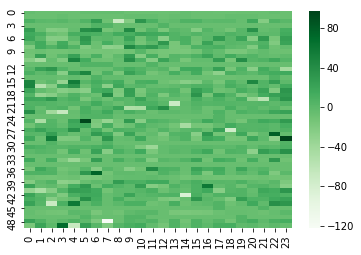

In [211]:
import seaborn as sns
sns.heatmap(params[0].data.numpy(),cmap='Greens')

In [212]:
pred.mean(dim=0)

Variable containing:
  692.5599
  588.0663
  501.3743
  460.1837
  436.3798
  355.5527
  311.9684
  297.6341
  322.5244
  428.9862
  592.4996
  772.2503
  966.1185
 1127.9465
 1314.9707
 1500.3232
 1605.3037
 1614.2816
 1443.5745
 1331.0858
 1250.1410
 1152.5958
  989.2106
  826.7234
[torch.FloatTensor of size 24]

In [213]:
test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
if cuda_av:
    test_inp = test_inp.cuda()

params = [test_inp, -2]
for i in range(len(ORDER)):
    params.append(None)
pr = a(*params)
pr = torch.clamp(pr, min=0.)
test_pred = torch.split(pr, test_aggregate.shape[0])
prediction_fold = [None for x in range(len(ORDER))]

if cuda_av:
    for appliance_num, appliance in enumerate(ORDER):
        prediction_fold[appliance_num] = test_pred[appliance_num].cpu().data.numpy().reshape(-1, 24)
else:
    for appliance_num, appliance in enumerate(ORDER):
        prediction_fold[appliance_num] = test_pred[appliance_num].data.numpy().reshape(-1, 24)
gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    gt_fold[appliance_num] = test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(test_aggregate.shape[0], -1,
                                                                                         1).reshape(-1, 24)

In [214]:
ORDER

['hvac']

In [215]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(prediction_fold[0], gt_fold[0])

391.65576299356121

In [174]:
test_aggregate.shape

(1568, 24)

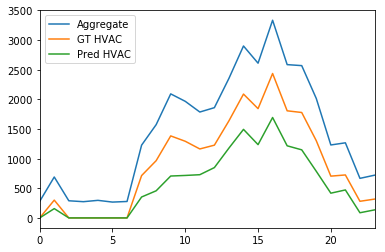

In [176]:
%matplotlib inline
import matplotlib.pyplot as plt
pd.Series(test_aggregate[0, :]).plot(label='Aggregate')
pd.Series(gt_fold[0][0, :]).plot(label='GT HVAC')



pd.Series(prediction_fold[0][0, :]).plot(label='Pred HVAC')
plt.legend()

In [154]:
prediction_fold[0].mean(), gt_fold[0].mean()

(875.61389, 967.38570311370972)

In [158]:
pd.DataFrame(gt_fold[0] -prediction_fold[0]).describe()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
count,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,...,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000
mean,14.330924,20.724476,9.986819,23.465321,8.555843,96.534964,124.526723,82.631098,152.807498,185.336259,...,197.788918,261.715500,153.305507,167.875911,124.751287,130.766336,2.382427,-79.370567,-68.270771,-29.491672
std,374.807924,326.324415,349.634097,317.139570,277.962131,312.268887,334.405420,328.685361,376.570637,451.449221,...,739.848862,798.793626,789.410504,782.699284,773.531189,719.809046,672.864351,670.745804,543.348145,437.008175
min,-1991.519470,-2231.807556,-2444.707397,-1544.608795,-1366.978271,-1514.400940,-1339.450333,-1440.022751,-1477.097137,-1402.004761,...,-2427.691406,-2344.594666,-2615.395752,-2415.982239,-2725.293213,-2334.186707,-2502.229156,-2728.680542,-3187.554688,-2253.156738
25%,-77.748543,-74.101425,-52.188568,-51.195663,-76.941391,-27.155823,-10.746002,-15.836380,0.000000,0.000000,...,0.000000,-6.256500,-205.361816,-112.394806,-249.058990,-241.526215,-354.339622,-414.751602,-296.767380,-189.185482
50%,78.203903,35.951047,68.024851,51.701599,3.965500,63.243921,53.126801,15.646606,94.160400,147.525970,...,353.263245,408.651001,259.760254,283.541870,235.865967,227.767998,74.560730,13.756317,13.382217,34.712128
75%,191.879303,178.767662,174.636322,172.336594,133.941986,250.893982,281.788841,231.804501,326.001732,350.257523,...,584.534454,664.610519,587.290298,602.863434,534.078011,537.251999,320.982529,208.241928,180.414696,156.053841
max,1963.380676,1610.667542,1137.516724,1196.493561,1773.279968,1708.482452,2340.289581,2127.651611,2067.201965,2657.900269,...,2409.071106,3047.466553,2655.514648,2340.164490,2674.489136,2650.834045,2998.276688,2835.364914,2352.399902,2642.561035


In [54]:
prediction_fold[0].mean()

912.51764

In [313]:
%matplotlib inline

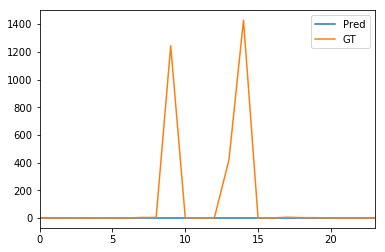

In [373]:
import matplotlib.pyplot as plt
pd.DataFrame(prediction_fold[0]).iloc[10].plot(label='Pred')
pd.DataFrame(gt_fold[0]).iloc[10].plot(label='GT')
plt.legend()

In [1]:



print([x.mean() for x in pred_split])
error = pd.Series({appliance:mean_absolute_error(gt_fold[appliance_num], prediction_fold[appliance_num]) for appliance_num, appliance in enumerate(ORDER)})

NameError: name 'cell_type' is not defined